In [81]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [82]:
import os

# Change the directory to your scratch folder
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

In [83]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [84]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [1]:
import pandas as pd

icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")
icd_code_names = icd_data.columns[4:]

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_21658/1336925752.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")


In [2]:
icd_code_names

Index(['3', '4', '5', '7', '8', '9', '11', '12', '13', '14',
       ...
       '989', '990', '991', '992', '994', '995', '996', '997', '998', '999'],
      dtype='object', length=837)

In [3]:
icd_data.head()

,patientid,hospitalid,death,readmission,3,4,5,7,8,9,...,989,990,991,992,994,995,996,997,998,999
0,35,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,36,2001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,37,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,38,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
4,41,2001,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
icd_data[(icd_data["hospitalid"] == 1001) & (icd_data["readmission"] == 1)]

,patientid,hospitalid,death,readmission,3,4,5,7,8,9,...,989,990,991,992,994,995,996,997,998,999
38879,002-72371,1001,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38880,002-67735,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38882,002-75420,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38902,002-8557,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38906,002-27053,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156683,035-3709,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156698,035-9430,1001,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156717,035-4293,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156763,035-4875,1001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [87]:
# mimic_data = icd_data[icd_data]

In [88]:
mimic_data = icd_data[icd_data["hospitalid"] == 2001]
eicu_data = icd_data[icd_data["hospitalid"] == 1001]

mimic_icds = mimic_data.iloc[:, 4:].to_numpy()
eicu_icds = eicu_data.iloc[:, 4:].to_numpy()

In [89]:
t_hidden_size = 512
rho_size = 512
num_topics = 64
enc_drop = 0.2

In [90]:
def top_k_precision(y_true, y_probs, k=3):
    top_k_indices = np.argsort(y_probs)[-k:][::-1]
    true_positives_in_top_k = np.sum(y_true[top_k_indices])
    top_k_precision = true_positives_in_top_k / k
    return top_k_precision

In [91]:
import torch.nn as nn
import torch.nn.functional as F

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)

        ## define the word embedding matrix \rho
        self.rho = nn.Linear(rho_size, vocab_size, bias=False)

        # with torch.no_grad():
        #     self.rho.weight = nn.Parameter(pretrained_rho_tensor.T)
        #     self.rho.weight.requires_grad = False

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)

        ## define variational distribution for \theta_{1:D} via amortizartion
        # print(vocab_size, " THE Vocabulary size is here ")
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                nn.ReLU(),
            )

        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            # During inference time, there is no need for random sampling.
            # Instead, the model can use the mean directly, which is a point estimate of the latent variable
            # This avoids unnecessary randomness during inference or testing.
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()

        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        """
        This generate the description as a defintion over words

        Returns:
            [type]: [description]
        """
        try:
            logit = self.alphas(self.rho.weight) # torch.mm(self.rho, self.alphas)
        except:
            logit = self.alphas(self.rho)
        # logit = self.alphas(self.rho.weight.T)
        beta = F.softmax(logit, dim=0).transpose(1, 0) ## softmax over vocab dimension
        return beta

    def get_theta(self, normalized_bows, is_train=True, d=1.0):
        """
        getting the topic poportion for the document passed in the normalixe bow or tf-idf"""
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        if not is_train:
            theta = F.softmax(z / d, dim=-1)
        return z, theta, kld_theta

    def decode(self, theta, beta):
        """compute the probability of topic given the document which is equal to theta^T ** B

        Args:
            theta ([type]): [description]
            beta ([type]): [description]

        Returns:
            [type]: [description]
        """
        res = torch.mm(theta, beta)

        almost_zeros = torch.full_like(res, 1e-6)
        results_without_zeros = res.add(almost_zeros)
        predictions = torch.log(results_without_zeros)
        return predictions

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            _, theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [92]:
import torch
import numpy as np

etm_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
etm_mimic_client_model.load_state_dict(
    torch.load('../result/etm_64_mimic_client_model.pth', map_location=device)
)
etm_mimic_client_model.eval()

etm_mimic_train_icds = np.load("../result/etm_64_mimic_train_icds.npy")
etm_mimic_test_icds = np.load("../result/etm_64_mimic_test_icds.npy")
etm_mimic_train_readmit_row_ids = np.load("../result/etm_64_mimic_train_readmit_row_ids.npy")
etm_mimic_test_readmit_row_ids = np.load("../result/etm_64_mimic_test_readmit_row_ids.npy")
etm_mimic_train_label_deaths = np.load("../result/etm_64_mimic_train_label_deaths.npy")
etm_mimic_test_label_deaths = np.load("../result/etm_64_mimic_test_label_deaths.npy")

etm_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
etm_eicu_client_model.load_state_dict(
    torch.load('../result/etm_64_eicu_client_model.pth', map_location=device)
)
etm_eicu_client_model.eval()

etm_eicu_train_icds = np.load("../result/etm_64_eicu_train_icds.npy")
etm_eicu_test_icds = np.load("../result/etm_64_eicu_test_icds.npy")
etm_eicu_train_readmit_row_ids = np.load("../result/etm_64_eicu_train_readmit_row_ids.npy")
etm_eicu_test_readmit_row_ids = np.load("../result/etm_64_eicu_test_readmit_row_ids.npy")
etm_eicu_train_label_deaths = np.load("../result/etm_64_eicu_train_label_deaths.npy")
etm_eicu_test_label_deaths = np.load("../result/etm_64_eicu_test_label_deaths.npy")

In [93]:
import torch
import numpy as np

unweighted_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
unweighted_mimic_client_model.load_state_dict(
    torch.load('../result/fedavg_etm_64mimic_client_model.pth', map_location=device)
)
unweighted_mimic_client_model.eval()

unweighted_mimic_train_icds = np.load("../result/fedavg_etm_64mimic_train_icds.npy")
unweighted_mimic_test_icds = np.load("../result/fedavg_etm_64mimic_test_icds.npy")
unweighted_mimic_train_readmit_row_ids = np.load("../result/fedavg_etm_64mimic_train_readmit_row_ids.npy")
unweighted_mimic_test_readmit_row_ids = np.load("../result/fedavg_etm_64mimic_test_readmit_row_ids.npy")
unweighted_mimic_train_label_deaths = np.load("../result/fedavg_etm_64mimic_train_label_deaths.npy")
unweighted_mimic_test_label_deaths = np.load("../result/fedavg_etm_64mimic_test_label_deaths.npy")

unweighted_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
unweighted_eicu_client_model.load_state_dict(
    torch.load('../result/fedavg_etm_64eicu_client_model.pth', map_location=device)
)
unweighted_eicu_client_model.eval()

unweighted_eicu_train_icds = np.load("../result/fedavg_etm_64eicu_train_icds.npy")
unweighted_eicu_test_icds = np.load("../result/fedavg_etm_64eicu_test_icds.npy")
unweighted_eicu_train_readmit_row_ids = np.load("../result/fedavg_etm_64eicu_train_readmit_row_ids.npy")
unweighted_eicu_test_readmit_row_ids = np.load("../result/fedavg_etm_64eicu_test_readmit_row_ids.npy")
unweighted_eicu_train_label_deaths = np.load("../result/fedavg_etm_64eicu_train_label_deaths.npy")
unweighted_eicu_test_label_deaths = np.load("../result/fedavg_etm_64eicu_test_label_deaths.npy")

In [94]:
import torch
import numpy as np

weighted_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_mimic_client_model.load_state_dict(
    torch.load('../result/fedweight_etm_64mimic_client_model.pth', map_location=device)
)
weighted_mimic_client_model.eval()

weighted_mimic_train_icds = np.load("../result/fedweight_etm_64mimic_train_icds.npy")
weighted_mimic_test_icds = np.load("../result/fedweight_etm_64mimic_test_icds.npy")
weighted_mimic_train_readmit_row_ids = np.load("../result/fedweight_etm_64mimic_train_readmit_row_ids.npy")
weighted_mimic_test_readmit_row_ids = np.load("../result/fedweight_etm_64mimic_test_readmit_row_ids.npy")
weighted_mimic_train_label_deaths = np.load("../result/fedweight_etm_64mimic_train_label_deaths.npy")
weighted_mimic_test_label_deaths = np.load("../result/fedweight_etm_64mimic_test_label_deaths.npy")

weighted_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_eicu_client_model.load_state_dict(
    torch.load('../result/fedweight_etm_64eicu_client_model.pth', map_location=device)
)
weighted_eicu_client_model.eval()

weighted_eicu_train_icds = np.load("../result/fedweight_etm_64eicu_train_icds.npy")
weighted_eicu_test_icds = np.load("../result/fedweight_etm_64eicu_test_icds.npy")
weighted_eicu_train_readmit_row_ids = np.load("../result/fedweight_etm_64eicu_train_readmit_row_ids.npy")
weighted_eicu_test_readmit_row_ids = np.load("../result/fedweight_etm_64eicu_test_readmit_row_ids.npy")
weighted_eicu_train_label_deaths = np.load("../result/fedweight_etm_64eicu_train_label_deaths.npy")
weighted_eicu_test_label_deaths = np.load("../result/fedweight_etm_64eicu_test_label_deaths.npy")

In [95]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

unweighted_eicu_train_tensor = torch.tensor(unweighted_eicu_train_icds)
unweighted_eicu_test_tensor = torch.tensor(unweighted_eicu_test_icds)

_, eicu_train_theta_unweighted, _ = unweighted_eicu_client_model.get_theta(unweighted_eicu_train_tensor)
_, eicu_on_eicu_test_theta_unweighted, _ = unweighted_eicu_client_model.get_theta(unweighted_eicu_test_tensor)

eicu_train_theta_unweighted = eicu_train_theta_unweighted.data.cpu().numpy()
eicu_on_eicu_test_theta_unweighted = eicu_on_eicu_test_theta_unweighted.data.cpu().numpy()

print(eicu_train_theta_unweighted.shape)
print(eicu_on_eicu_test_theta_unweighted.shape)

X_eicu_train_unweighted = eicu_train_theta_unweighted[unweighted_eicu_train_readmit_row_ids]
X_eicu_on_eicu_test_unweighted = eicu_on_eicu_test_theta_unweighted[unweighted_eicu_test_readmit_row_ids]

print("X_eicu_train_unweighted ", X_eicu_train_unweighted.shape)
print("X_eicu_on_eicu_test_unweighted ", X_eicu_on_eicu_test_unweighted.shape)

knn_eicu_unweighted = KNeighborsClassifier(n_neighbors=75)
knn_eicu_unweighted.fit(X_eicu_train_unweighted, unweighted_eicu_train_label_deaths)

unweighted_eicu_on_eicu_top_k_precision_scores = []
unweighted_eicu_on_eicu_auroc_list = []
unweighted_eicu_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_eicu_test_unweighted, unweighted_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    unweighted_eicu_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_unweighted = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_unweighted)
    unweighted_eicu_on_eicu_auroc_list.append(unweighted_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_unweighted = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_unweighted)
    unweighted_eicu_on_eicu_auprc_list.append(unweighted_eicu_auprc)
    
unweighted_eicu_on_eicu_mean_top_k_precision = np.mean(unweighted_eicu_on_eicu_top_k_precision_scores)
unweighted_eicu_on_eicu_std_top_k_precision = np.std(unweighted_eicu_on_eicu_top_k_precision_scores)

unweighted_eicu_on_eicu_mean_auroc = np.mean(unweighted_eicu_on_eicu_auroc_list)
unweighted_eicu_on_eicu_std_auroc = np.std(unweighted_eicu_on_eicu_auroc_list)

unweighted_eicu_on_eicu_mean_auprc = np.mean(unweighted_eicu_on_eicu_auprc_list)
unweighted_eicu_on_eicu_std_auprc = np.std(unweighted_eicu_on_eicu_auprc_list)



import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

unweighted_mimic_train_tensor = torch.tensor(unweighted_mimic_train_icds)
unweighted_mimic_test_tensor = torch.tensor(unweighted_mimic_test_icds)

_, mimic_train_theta_unweighted, _ = unweighted_mimic_client_model.get_theta(unweighted_mimic_train_tensor)
_, mimic_on_mimic_test_theta_unweighted, _ = unweighted_mimic_client_model.get_theta(unweighted_mimic_test_tensor)

mimic_train_theta_unweighted = mimic_train_theta_unweighted.data.cpu().numpy()
mimic_on_mimic_test_theta_unweighted = mimic_on_mimic_test_theta_unweighted.data.cpu().numpy()

print(mimic_train_theta_unweighted.shape)
print(mimic_on_mimic_test_theta_unweighted.shape)

X_mimic_train_unweighted = mimic_train_theta_unweighted[unweighted_mimic_train_readmit_row_ids]
X_mimic_on_mimic_test_unweighted = mimic_on_mimic_test_theta_unweighted[unweighted_mimic_test_readmit_row_ids]

print("X_mimic_train_unweighted ", X_mimic_train_unweighted.shape)
print("X_mimic_on_mimic_test_unweighted ", X_mimic_on_mimic_test_unweighted.shape)

knn_mimic_unweighted = KNeighborsClassifier(n_neighbors=75)
knn_mimic_unweighted.fit(X_mimic_train_unweighted, unweighted_mimic_train_label_deaths)

unweighted_mimic_on_mimic_top_k_precision_scores = []
unweighted_mimic_on_mimic_auroc_list = []
unweighted_mimic_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_mimic_test_unweighted, unweighted_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    unweighted_mimic_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_unweighted = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_unweighted)
    unweighted_mimic_on_mimic_auroc_list.append(unweighted_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_unweighted = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_unweighted)
    unweighted_mimic_on_mimic_auprc_list.append(unweighted_mimic_auprc)
    
unweighted_mimic_on_mimic_mean_top_k_precision = np.mean(unweighted_mimic_on_mimic_top_k_precision_scores)
unweighted_mimic_on_mimic_std_top_k_precision = np.std(unweighted_mimic_on_mimic_top_k_precision_scores)

unweighted_mimic_on_mimic_mean_auroc = np.mean(unweighted_mimic_on_mimic_auroc_list)
unweighted_mimic_on_mimic_std_auroc = np.std(unweighted_mimic_on_mimic_auroc_list)

unweighted_mimic_on_mimic_mean_auprc = np.mean(unweighted_mimic_on_mimic_auprc_list)
unweighted_mimic_on_mimic_std_auprc = np.std(unweighted_mimic_on_mimic_auprc_list)

(94342, 64)
(23586, 64)
X_eicu_train_unweighted  (5420, 64)
X_eicu_on_eicu_test_unweighted  (1310, 64)
(31099, 64)
(7775, 64)
X_mimic_train_unweighted  (5846, 64)
X_mimic_on_mimic_test_unweighted  (1460, 64)


In [96]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

unweighted_eicu_train_tensor = torch.tensor(unweighted_eicu_train_icds)
unweighted_mimic_test_tensor = torch.tensor(unweighted_mimic_test_icds)

_, eicu_train_theta_unweighted, _ = unweighted_eicu_client_model.get_theta(unweighted_eicu_train_tensor)
_, eicu_on_mimic_test_theta_unweighted, _ = unweighted_eicu_client_model.get_theta(unweighted_mimic_test_tensor)

eicu_train_theta_unweighted = eicu_train_theta_unweighted.data.cpu().numpy()
eicu_on_mimic_test_theta_unweighted = eicu_on_mimic_test_theta_unweighted.data.cpu().numpy()

print(eicu_train_theta_unweighted.shape)
print(eicu_on_mimic_test_theta_unweighted.shape)

X_eicu_train_unweighted = eicu_train_theta_unweighted[unweighted_eicu_train_readmit_row_ids]
X_eicu_on_mimic_test_unweighted = eicu_on_mimic_test_theta_unweighted[unweighted_mimic_test_readmit_row_ids]

print("X_eicu_train_unweighted ", X_eicu_train_unweighted.shape)
print("X_eicu_on_mimic_test_unweighted ", X_eicu_on_mimic_test_unweighted.shape)

knn_eicu_unweighted = KNeighborsClassifier(n_neighbors=75)
knn_eicu_unweighted.fit(X_eicu_train_unweighted, unweighted_eicu_train_label_deaths)

unweighted_eicu_on_mimic_top_k_precision_scores = []
unweighted_eicu_on_mimic_auroc_list = []
unweighted_eicu_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_mimic_test_unweighted, unweighted_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    unweighted_eicu_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_unweighted = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_unweighted)
    unweighted_eicu_on_mimic_auroc_list.append(unweighted_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_unweighted = knn_eicu_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_unweighted)
    unweighted_eicu_on_mimic_auprc_list.append(unweighted_mimic_auprc)
    
unweighted_eicu_on_mimic_mean_top_k_precision = np.mean(unweighted_eicu_on_mimic_top_k_precision_scores)
unweighted_eicu_on_mimic_std_top_k_precision = np.std(unweighted_eicu_on_mimic_top_k_precision_scores)

unweighted_eicu_on_mimic_mean_auroc = np.mean(unweighted_eicu_on_mimic_auroc_list)
unweighted_eicu_on_mimic_std_auroc = np.std(unweighted_eicu_on_mimic_auroc_list)

unweighted_eicu_on_mimic_mean_auprc = np.mean(unweighted_eicu_on_mimic_auprc_list)
unweighted_eicu_on_mimic_std_auprc = np.std(unweighted_eicu_on_mimic_auprc_list)

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

unweighted_mimic_train_tensor = torch.tensor(unweighted_mimic_train_icds)
unweighted_eicu_test_tensor = torch.tensor(unweighted_eicu_test_icds)

_, mimic_train_theta_unweighted, _ = unweighted_mimic_client_model.get_theta(unweighted_mimic_train_tensor)
_, mimic_on_eicu_test_theta_unweighted, _ = unweighted_mimic_client_model.get_theta(unweighted_eicu_test_tensor)

mimic_train_theta_unweighted = mimic_train_theta_unweighted.data.cpu().numpy()
mimic_on_eicu_test_theta_unweighted = mimic_on_eicu_test_theta_unweighted.data.cpu().numpy()

print(mimic_train_theta_unweighted.shape)
print(mimic_on_eicu_test_theta_unweighted.shape)

X_mimic_train_unweighted = mimic_train_theta_unweighted[unweighted_mimic_train_readmit_row_ids]
X_mimic_on_eicu_test_unweighted = mimic_on_eicu_test_theta_unweighted[unweighted_eicu_test_readmit_row_ids]

print("X_mimic_train_unweighted ", X_mimic_train_unweighted.shape)
print("X_mimic_on_eicu_test_unweighted ", X_mimic_on_eicu_test_unweighted.shape)

knn_mimic_unweighted = KNeighborsClassifier(n_neighbors=75)
knn_mimic_unweighted.fit(X_mimic_train_unweighted, unweighted_mimic_train_label_deaths)

unweighted_mimic_on_eicu_top_k_precision_scores = []
unweighted_mimic_on_eicu_auroc_list = []
unweighted_mimic_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_eicu_test_unweighted, unweighted_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    unweighted_mimic_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_unweighted = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_unweighted)
    unweighted_mimic_on_eicu_auroc_list.append(unweighted_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_unweighted = knn_mimic_unweighted.predict_proba(X_bootstrap)[:, 1]
    unweighted_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_unweighted)
    unweighted_mimic_on_eicu_auprc_list.append(unweighted_eicu_auprc)
    
unweighted_mimic_on_eicu_mean_top_k_precision = np.mean(unweighted_mimic_on_eicu_top_k_precision_scores)
unweighted_mimic_on_eicu_std_top_k_precision = np.std(unweighted_mimic_on_eicu_top_k_precision_scores)

unweighted_mimic_on_eicu_mean_auroc = np.mean(unweighted_mimic_on_eicu_auroc_list)
unweighted_mimic_on_eicu_std_auroc = np.std(unweighted_mimic_on_eicu_auroc_list)

unweighted_mimic_on_eicu_mean_auprc = np.mean(unweighted_mimic_on_eicu_auprc_list)
unweighted_mimic_on_eicu_std_auprc = np.std(unweighted_mimic_on_eicu_auprc_list)

(94342, 64)
(7775, 64)
X_eicu_train_unweighted  (5420, 64)
X_eicu_on_mimic_test_unweighted  (1460, 64)
(31099, 64)
(23586, 64)
X_mimic_train_unweighted  (5846, 64)
X_mimic_on_eicu_test_unweighted  (1310, 64)


In [97]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

etm_eicu_train_tensor = torch.tensor(etm_eicu_train_icds)
etm_eicu_test_tensor = torch.tensor(etm_eicu_test_icds)

_, eicu_train_theta_etm, _ = etm_eicu_client_model.get_theta(etm_eicu_train_tensor)
_, eicu_on_eicu_test_theta_etm, _ = etm_eicu_client_model.get_theta(etm_eicu_test_tensor)

eicu_train_theta_etm = eicu_train_theta_etm.data.cpu().numpy()
eicu_on_eicu_test_theta_etm = eicu_on_eicu_test_theta_etm.data.cpu().numpy()

print(eicu_train_theta_etm.shape)
print(eicu_on_eicu_test_theta_etm.shape)

X_eicu_train_etm = eicu_train_theta_etm[etm_eicu_train_readmit_row_ids]
X_eicu_on_eicu_test_etm = eicu_on_eicu_test_theta_etm[etm_eicu_test_readmit_row_ids]

print("X_eicu_train_etm ", X_eicu_train_etm.shape)
print("X_eicu_on_eicu_test_etm ", X_eicu_on_eicu_test_etm.shape)

knn_eicu_etm = KNeighborsClassifier(n_neighbors=75)
knn_eicu_etm.fit(X_eicu_train_etm, etm_eicu_train_label_deaths)

etm_eicu_on_eicu_top_k_precision_scores = []
etm_eicu_on_eicu_auroc_list = []
etm_eicu_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_eicu_test_etm, etm_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    etm_eicu_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_etm = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]
    etm_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_etm)
    etm_eicu_on_eicu_auroc_list.append(etm_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_etm = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]
    etm_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_etm)
    etm_eicu_on_eicu_auprc_list.append(etm_eicu_auprc)
    
etm_eicu_on_eicu_mean_top_k_precision = np.mean(etm_eicu_on_eicu_top_k_precision_scores)
etm_eicu_on_eicu_std_top_k_precision = np.std(etm_eicu_on_eicu_top_k_precision_scores)

etm_eicu_on_eicu_mean_auroc = np.mean(etm_eicu_on_eicu_auroc_list)
etm_eicu_on_eicu_std_auroc = np.std(etm_eicu_on_eicu_auroc_list)

etm_eicu_on_eicu_mean_auprc = np.mean(etm_eicu_on_eicu_auprc_list)
etm_eicu_on_eicu_std_auprc = np.std(etm_eicu_on_eicu_auprc_list)


import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

etm_mimic_train_tensor = torch.tensor(etm_mimic_train_icds)
etm_mimic_test_tensor = torch.tensor(etm_mimic_test_icds)

_, mimic_train_theta_etm, _ = etm_mimic_client_model.get_theta(etm_mimic_train_tensor)
_, mimic_on_mimic_test_theta_etm, _ = etm_mimic_client_model.get_theta(etm_mimic_test_tensor)

mimic_train_theta_etm = mimic_train_theta_etm.data.cpu().numpy()
mimic_on_mimic_test_theta_etm = mimic_on_mimic_test_theta_etm.data.cpu().numpy()

print(mimic_train_theta_etm.shape)
print(mimic_on_mimic_test_theta_etm.shape)

X_mimic_train_etm = mimic_train_theta_etm[etm_mimic_train_readmit_row_ids]
X_mimic_on_mimic_test_etm = mimic_on_mimic_test_theta_etm[etm_mimic_test_readmit_row_ids]

print("X_mimic_train_etm ", X_mimic_train_etm.shape)
print("X_mimic_on_mimic_test_etm ", X_mimic_on_mimic_test_etm.shape)

knn_mimic_etm = KNeighborsClassifier(n_neighbors=75)
knn_mimic_etm.fit(X_mimic_train_etm, etm_mimic_train_label_deaths)

etm_mimic_on_mimic_top_k_precision_scores = []
etm_mimic_on_mimic_auroc_list = []
etm_mimic_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_mimic_test_etm, etm_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    etm_mimic_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_etm = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]
    etm_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_etm)
    etm_mimic_on_mimic_auroc_list.append(etm_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_etm = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]
    etm_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_etm)
    etm_mimic_on_mimic_auprc_list.append(etm_mimic_auprc)
    
etm_mimic_on_mimic_mean_top_k_precision = np.mean(etm_mimic_on_mimic_top_k_precision_scores)
etm_mimic_on_mimic_std_top_k_precision = np.std(etm_mimic_on_mimic_top_k_precision_scores)

etm_mimic_on_mimic_mean_auroc = np.mean(etm_mimic_on_mimic_auroc_list)
etm_mimic_on_mimic_std_auroc = np.std(etm_mimic_on_mimic_auroc_list)

etm_mimic_on_mimic_mean_auprc = np.mean(etm_mimic_on_mimic_auprc_list)
etm_mimic_on_mimic_std_auprc = np.std(etm_mimic_on_mimic_auprc_list)

(94342, 64)
(23586, 64)
X_eicu_train_etm  (5420, 64)
X_eicu_on_eicu_test_etm  (1310, 64)
(31099, 64)
(7775, 64)
X_mimic_train_etm  (5846, 64)
X_mimic_on_mimic_test_etm  (1460, 64)


In [98]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

etm_eicu_train_tensor = torch.tensor(etm_eicu_train_icds)
etm_mimic_test_tensor = torch.tensor(etm_mimic_test_icds)

_, eicu_train_theta_etm, _ = etm_eicu_client_model.get_theta(etm_eicu_train_tensor)
_, eicu_on_mimic_test_theta_etm, _ = etm_eicu_client_model.get_theta(etm_mimic_test_tensor)

eicu_train_theta_etm = eicu_train_theta_etm.data.cpu().numpy()
eicu_on_mimic_test_theta_etm = eicu_on_mimic_test_theta_etm.data.cpu().numpy()

print(eicu_train_theta_etm.shape)
print(eicu_on_mimic_test_theta_etm.shape)

X_eicu_train_etm = eicu_train_theta_etm[etm_eicu_train_readmit_row_ids]
X_eicu_on_mimic_test_etm = eicu_on_mimic_test_theta_etm[etm_mimic_test_readmit_row_ids]

print("X_eicu_train_etm ", X_eicu_train_etm.shape)
print("X_eicu_on_mimic_test_etm ", X_eicu_on_mimic_test_etm.shape)

knn_eicu_etm = KNeighborsClassifier(n_neighbors=75)
knn_eicu_etm.fit(X_eicu_train_etm, etm_eicu_train_label_deaths)

etm_eicu_on_mimic_top_k_precision_scores = []
etm_eicu_on_mimic_auroc_list = []
etm_eicu_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_mimic_test_etm, etm_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    etm_eicu_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_etm = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]
    etm_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_etm)
    etm_eicu_on_mimic_auroc_list.append(etm_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_etm = knn_eicu_etm.predict_proba(X_bootstrap)[:, 1]
    etm_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_etm)
    etm_eicu_on_mimic_auprc_list.append(etm_mimic_auprc)
    
etm_eicu_on_mimic_mean_top_k_precision = np.mean(etm_eicu_on_mimic_top_k_precision_scores)
etm_eicu_on_mimic_std_top_k_precision = np.std(etm_eicu_on_mimic_top_k_precision_scores)

etm_eicu_on_mimic_mean_auroc = np.mean(etm_eicu_on_mimic_auroc_list)
etm_eicu_on_mimic_std_auroc = np.std(etm_eicu_on_mimic_auroc_list)

etm_eicu_on_mimic_mean_auprc = np.mean(etm_eicu_on_mimic_auprc_list)
etm_eicu_on_mimic_std_auprc = np.std(etm_eicu_on_mimic_auprc_list)

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

etm_mimic_train_tensor = torch.tensor(etm_mimic_train_icds)
etm_eicu_test_tensor = torch.tensor(etm_eicu_test_icds)

_, mimic_train_theta_etm, _ = etm_mimic_client_model.get_theta(etm_mimic_train_tensor)
_, mimic_on_eicu_test_theta_etm, _ = etm_mimic_client_model.get_theta(etm_eicu_test_tensor)

mimic_train_theta_etm = mimic_train_theta_etm.data.cpu().numpy()
mimic_on_eicu_test_theta_etm = mimic_on_eicu_test_theta_etm.data.cpu().numpy()

print(mimic_train_theta_etm.shape)
print(mimic_on_eicu_test_theta_etm.shape)

X_mimic_train_etm = mimic_train_theta_etm[etm_mimic_train_readmit_row_ids]
X_mimic_on_eicu_test_etm = mimic_on_eicu_test_theta_etm[etm_eicu_test_readmit_row_ids]

print("X_mimic_train_etm ", X_mimic_train_etm.shape)
print("X_mimic_on_eicu_test_etm ", X_mimic_on_eicu_test_etm.shape)

knn_mimic_etm = KNeighborsClassifier(n_neighbors=75)
knn_mimic_etm.fit(X_mimic_train_etm, etm_mimic_train_label_deaths)

etm_mimic_on_eicu_top_k_precision_scores = []
etm_mimic_on_eicu_auroc_list = []
etm_mimic_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_eicu_test_etm, etm_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    etm_mimic_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_etm = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]
    etm_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_etm)
    etm_mimic_on_eicu_auroc_list.append(etm_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_etm = knn_mimic_etm.predict_proba(X_bootstrap)[:, 1]
    etm_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_etm)
    etm_mimic_on_eicu_auprc_list.append(etm_eicu_auprc)
    
etm_mimic_on_eicu_mean_top_k_precision = np.mean(etm_mimic_on_eicu_top_k_precision_scores)
etm_mimic_on_eicu_std_top_k_precision = np.std(etm_mimic_on_eicu_top_k_precision_scores)

etm_mimic_on_eicu_mean_auroc = np.mean(etm_mimic_on_eicu_auroc_list)
etm_mimic_on_eicu_std_auroc = np.std(etm_mimic_on_eicu_auroc_list)

etm_mimic_on_eicu_mean_auprc = np.mean(etm_mimic_on_eicu_auprc_list)
etm_mimic_on_eicu_std_auprc = np.std(etm_mimic_on_eicu_auprc_list)

(94342, 64)
(7775, 64)
X_eicu_train_etm  (5420, 64)
X_eicu_on_mimic_test_etm  (1460, 64)
(31099, 64)
(23586, 64)
X_mimic_train_etm  (5846, 64)
X_mimic_on_eicu_test_etm  (1310, 64)


In [99]:


import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

weighted_eicu_train_tensor = torch.tensor(weighted_eicu_train_icds)
weighted_eicu_test_tensor = torch.tensor(weighted_eicu_test_icds)

_, eicu_train_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_eicu_train_tensor)
_, eicu_on_eicu_test_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_eicu_test_tensor)

eicu_train_theta_weighted = eicu_train_theta_weighted.data.cpu().numpy()
eicu_on_eicu_test_theta_weighted = eicu_on_eicu_test_theta_weighted.data.cpu().numpy()

print(eicu_train_theta_weighted.shape)
print(eicu_on_eicu_test_theta_weighted.shape)

X_eicu_train_weighted = eicu_train_theta_weighted[weighted_eicu_train_readmit_row_ids]
X_eicu_on_eicu_test_weighted = eicu_on_eicu_test_theta_weighted[weighted_eicu_test_readmit_row_ids]

print("X_eicu_train_weighted ", X_eicu_train_weighted.shape)
print("X_eicu_on_eicu_test_weighted ", X_eicu_on_eicu_test_weighted.shape)

knn_eicu_weighted = KNeighborsClassifier(n_neighbors=75)
knn_eicu_weighted.fit(X_eicu_train_weighted, weighted_eicu_train_label_deaths)

weighted_eicu_on_eicu_top_k_precision_scores = []
weighted_eicu_on_eicu_auroc_list = []
weighted_eicu_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_eicu_test_weighted, weighted_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    weighted_eicu_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_weighted = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_weighted)
    weighted_eicu_on_eicu_auroc_list.append(weighted_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_weighted = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_weighted)
    weighted_eicu_on_eicu_auprc_list.append(weighted_eicu_auprc)
    
weighted_eicu_on_eicu_mean_top_k_precision = np.mean(weighted_eicu_on_eicu_top_k_precision_scores)
weighted_eicu_on_eicu_std_top_k_precision = np.std(weighted_eicu_on_eicu_top_k_precision_scores)

weighted_eicu_on_eicu_mean_auroc = np.mean(weighted_eicu_on_eicu_auroc_list)
weighted_eicu_on_eicu_std_auroc = np.std(weighted_eicu_on_eicu_auroc_list)

weighted_eicu_on_eicu_mean_auprc = np.mean(weighted_eicu_on_eicu_auprc_list)
weighted_eicu_on_eicu_std_auprc = np.std(weighted_eicu_on_eicu_auprc_list)



import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

weighted_mimic_train_tensor = torch.tensor(weighted_mimic_train_icds)
weighted_mimic_test_tensor = torch.tensor(weighted_mimic_test_icds)

_, mimic_train_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_mimic_train_tensor)
_, mimic_on_mimic_test_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_mimic_test_tensor)

mimic_train_theta_weighted = mimic_train_theta_weighted.data.cpu().numpy()
mimic_on_mimic_test_theta_weighted = mimic_on_mimic_test_theta_weighted.data.cpu().numpy()

print(mimic_train_theta_weighted.shape)
print(mimic_on_mimic_test_theta_weighted.shape)

X_mimic_train_weighted = mimic_train_theta_weighted[weighted_mimic_train_readmit_row_ids]
X_mimic_on_mimic_test_weighted = mimic_on_mimic_test_theta_weighted[weighted_mimic_test_readmit_row_ids]

print("X_mimic_train_weighted ", X_mimic_train_weighted.shape)
print("X_mimic_on_mimic_test_weighted ", X_mimic_on_mimic_test_weighted.shape)

knn_mimic_weighted = KNeighborsClassifier(n_neighbors=75)
knn_mimic_weighted.fit(X_mimic_train_weighted, weighted_mimic_train_label_deaths)

weighted_mimic_on_mimic_top_k_precision_scores = []
weighted_mimic_on_mimic_auroc_list = []
weighted_mimic_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_mimic_test_weighted, weighted_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    weighted_mimic_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_weighted = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_weighted)
    weighted_mimic_on_mimic_auroc_list.append(weighted_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_weighted = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_weighted)
    weighted_mimic_on_mimic_auprc_list.append(weighted_mimic_auprc)
    
weighted_mimic_on_mimic_mean_top_k_precision = np.mean(weighted_mimic_on_mimic_top_k_precision_scores)
weighted_mimic_on_mimic_std_top_k_precision = np.std(weighted_mimic_on_mimic_top_k_precision_scores)

weighted_mimic_on_mimic_mean_auroc = np.mean(weighted_mimic_on_mimic_auroc_list)
weighted_mimic_on_mimic_std_auroc = np.std(weighted_mimic_on_mimic_auroc_list)

weighted_mimic_on_mimic_mean_auprc = np.mean(weighted_mimic_on_mimic_auprc_list)
weighted_mimic_on_mimic_std_auprc = np.std(weighted_mimic_on_mimic_auprc_list)

(94342, 64)
(23586, 64)
X_eicu_train_weighted  (5420, 64)
X_eicu_on_eicu_test_weighted  (1310, 64)
(31099, 64)
(7775, 64)
X_mimic_train_weighted  (5846, 64)
X_mimic_on_mimic_test_weighted  (1460, 64)


In [100]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

weighted_eicu_train_tensor = torch.tensor(weighted_eicu_train_icds)
weighted_mimic_test_tensor = torch.tensor(weighted_mimic_test_icds)

_, eicu_train_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_eicu_train_tensor)
_, eicu_on_mimic_test_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_mimic_test_tensor)

eicu_train_theta_weighted = eicu_train_theta_weighted.data.cpu().numpy()
eicu_on_mimic_test_theta_weighted = eicu_on_mimic_test_theta_weighted.data.cpu().numpy()

print(eicu_train_theta_weighted.shape)
print(eicu_on_mimic_test_theta_weighted.shape)

X_eicu_train_weighted = eicu_train_theta_weighted[weighted_eicu_train_readmit_row_ids]
X_eicu_on_mimic_test_weighted = eicu_on_mimic_test_theta_weighted[weighted_mimic_test_readmit_row_ids]

print("X_eicu_train_weighted ", X_eicu_train_weighted.shape)
print("X_eicu_on_mimic_test_weighted ", X_eicu_on_mimic_test_weighted.shape)

knn_eicu_weighted = KNeighborsClassifier(n_neighbors=75)
knn_eicu_weighted.fit(X_eicu_train_weighted, weighted_eicu_train_label_deaths)

weighted_eicu_on_mimic_top_k_precision_scores = []
weighted_eicu_on_mimic_auroc_list = []
weighted_eicu_on_mimic_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_eicu_on_mimic_test_weighted, weighted_mimic_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    weighted_eicu_on_mimic_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_mimic_weighted = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_mimic_auroc = roc_auc_score(y_bootstrap, y_knn_scores_mimic_weighted)
    weighted_eicu_on_mimic_auroc_list.append(weighted_mimic_auroc)
    
    # AUPRC
    y_knn_scores_mimic_weighted = knn_eicu_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_mimic_auprc = average_precision_score(y_bootstrap, y_knn_scores_mimic_weighted)
    weighted_eicu_on_mimic_auprc_list.append(weighted_mimic_auprc)
    
weighted_eicu_on_mimic_mean_top_k_precision = np.mean(weighted_eicu_on_mimic_top_k_precision_scores)
weighted_eicu_on_mimic_std_top_k_precision = np.std(weighted_eicu_on_mimic_top_k_precision_scores)

weighted_eicu_on_mimic_mean_auroc = np.mean(weighted_eicu_on_mimic_auroc_list)
weighted_eicu_on_mimic_std_auroc = np.std(weighted_eicu_on_mimic_auroc_list)

weighted_eicu_on_mimic_mean_auprc = np.mean(weighted_eicu_on_mimic_auprc_list)
weighted_eicu_on_mimic_std_auprc = np.std(weighted_eicu_on_mimic_auprc_list)

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

weighted_mimic_train_tensor = torch.tensor(weighted_mimic_train_icds)
weighted_eicu_test_tensor = torch.tensor(weighted_eicu_test_icds)

_, mimic_train_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_mimic_train_tensor)
_, mimic_on_eicu_test_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_eicu_test_tensor)

mimic_train_theta_weighted = mimic_train_theta_weighted.data.cpu().numpy()
mimic_on_eicu_test_theta_weighted = mimic_on_eicu_test_theta_weighted.data.cpu().numpy()

print(mimic_train_theta_weighted.shape)
print(mimic_on_eicu_test_theta_weighted.shape)

X_mimic_train_weighted = mimic_train_theta_weighted[weighted_mimic_train_readmit_row_ids]
X_mimic_on_eicu_test_weighted = mimic_on_eicu_test_theta_weighted[weighted_eicu_test_readmit_row_ids]

print("X_mimic_train_weighted ", X_mimic_train_weighted.shape)
print("X_mimic_on_eicu_test_weighted ", X_mimic_on_eicu_test_weighted.shape)

knn_mimic_weighted = KNeighborsClassifier(n_neighbors=75)
knn_mimic_weighted.fit(X_mimic_train_weighted, weighted_mimic_train_label_deaths)

weighted_mimic_on_eicu_top_k_precision_scores = []
weighted_mimic_on_eicu_auroc_list = []
weighted_mimic_on_eicu_auprc_list = []

for _ in range(100):

    X_bootstrap, y_bootstrap = resample(X_mimic_on_eicu_test_weighted, weighted_eicu_test_label_deaths, 
                                        n_samples=1000, replace=True)

    # Top K Precision
    y_bootstrap_knn_scores = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]

    top_k_precision_bootstrap = top_k_precision(y_bootstrap, y_bootstrap_knn_scores, k=100)
    weighted_mimic_on_eicu_top_k_precision_scores.append(top_k_precision_bootstrap)
    
    # AUROC
    y_knn_scores_eicu_weighted = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_eicu_auroc = roc_auc_score(y_bootstrap, y_knn_scores_eicu_weighted)
    weighted_mimic_on_eicu_auroc_list.append(weighted_eicu_auroc)
    
    # AUPRC
    y_knn_scores_eicu_weighted = knn_mimic_weighted.predict_proba(X_bootstrap)[:, 1]
    weighted_eicu_auprc = average_precision_score(y_bootstrap, y_knn_scores_eicu_weighted)
    weighted_mimic_on_eicu_auprc_list.append(weighted_eicu_auprc)
    
weighted_mimic_on_eicu_mean_top_k_precision = np.mean(weighted_mimic_on_eicu_top_k_precision_scores)
weighted_mimic_on_eicu_std_top_k_precision = np.std(weighted_mimic_on_eicu_top_k_precision_scores)

weighted_mimic_on_eicu_mean_auroc = np.mean(weighted_mimic_on_eicu_auroc_list)
weighted_mimic_on_eicu_std_auroc = np.std(weighted_mimic_on_eicu_auroc_list)

weighted_mimic_on_eicu_mean_auprc = np.mean(weighted_mimic_on_eicu_auprc_list)
weighted_mimic_on_eicu_std_auprc = np.std(weighted_mimic_on_eicu_auprc_list)

(94342, 64)
(7775, 64)
X_eicu_train_weighted  (5420, 64)
X_eicu_on_mimic_test_weighted  (1460, 64)
(31099, 64)
(23586, 64)
X_mimic_train_weighted  (5846, 64)
X_mimic_on_eicu_test_weighted  (1310, 64)


In [101]:
X_eicu_train_weighted

array([[0.0124302 , 0.01390321, 0.01222003, ..., 0.0128771 , 0.013922  ,
        0.01391768],
       [0.0128836 , 0.01361005, 0.01329614, ..., 0.01320097, 0.0136781 ,
        0.01366156],
       [0.01157667, 0.01255351, 0.01179736, ..., 0.01271569, 0.01263686,
        0.01262049],
       ...,
       [0.01076405, 0.01064645, 0.00963194, ..., 0.00982604, 0.0107944 ,
        0.01082701],
       [0.01265056, 0.01321058, 0.01279821, ..., 0.01290912, 0.01322796,
        0.01322133],
       [0.01169154, 0.01425894, 0.01186864, ..., 0.02182845, 0.01437267,
        0.01439832]], dtype=float32)

In [102]:
from scipy.stats import ranksums

_, unweighted_etm_mimic_on_mimic_auprc_p_value = ranksums(unweighted_mimic_on_mimic_auprc_list, etm_mimic_on_mimic_auprc_list)
_, weighted_etm_mimic_on_mimic_auprc_p_value = ranksums(weighted_mimic_on_mimic_auprc_list, etm_mimic_on_mimic_auprc_list)
_, weighted_unweighted_mimic_on_mimic_auprc_p_value = ranksums(weighted_mimic_on_mimic_auprc_list, unweighted_mimic_on_mimic_auprc_list)

print("Unweighted vs ETM mimic on MIMIC AUPRC p-value: ", unweighted_etm_mimic_on_mimic_auprc_p_value)
print("Weighted vs ETM mimic on MIMIC AUPRC p-value: ", weighted_etm_mimic_on_mimic_auprc_p_value)
print("Weighted vs Unweighted mimic on MIMIC AUPRC p-value: ", weighted_unweighted_mimic_on_mimic_auprc_p_value)

Unweighted vs ETM mimic on MIMIC AUPRC p-value:  0.9980504596707661
Weighted vs ETM mimic on MIMIC AUPRC p-value:  0.006734037954546988
Weighted vs Unweighted mimic on MIMIC AUPRC p-value:  0.010373769875797582


In [103]:
from scipy.stats import ranksums

_, unweighted_etm_eicu_on_eicu_auprc_p_value = ranksums(unweighted_eicu_on_eicu_auprc_list, etm_eicu_on_eicu_auprc_list)
_, weighted_etm_eicu_on_eicu_auprc_p_value = ranksums(weighted_eicu_on_eicu_auprc_list, etm_eicu_on_eicu_auprc_list)
_, weighted_unweighted_eicu_on_eicu_auprc_p_value = ranksums(weighted_eicu_on_eicu_auprc_list, unweighted_eicu_on_eicu_auprc_list)

print("Unweighted vs ETM eicu on eicu AUPRC p-value: ", unweighted_etm_eicu_on_eicu_auprc_p_value)
print("Weighted vs ETM eicu on eicu AUPRC p-value: ", weighted_etm_eicu_on_eicu_auprc_p_value)
print("Weighted vs Unweighted eicu on eicu AUPRC p-value: ", weighted_unweighted_eicu_on_eicu_auprc_p_value)

Unweighted vs ETM eicu on eicu AUPRC p-value:  0.5348491657242089
Weighted vs ETM eicu on eicu AUPRC p-value:  8.390522721833596e-12
Weighted vs Unweighted eicu on eicu AUPRC p-value:  2.901666272908345e-10


In [104]:
intra_compare_etm_cauprc_significance_index = []
intra_compare_etm_auprc_very_significance_index = []

# Compare FedAvg ETM and ETM
if unweighted_etm_mimic_on_mimic_auprc_p_value < 0.05 and etm_mimic_on_mimic_mean_auprc < unweighted_mimic_on_mimic_mean_auprc:
    if unweighted_etm_mimic_on_mimic_auprc_p_value < 0.01:
        intra_compare_etm_auprc_very_significance_index.append(0)
    else:
        intra_compare_etm_cauprc_significance_index.append(0)
        
if unweighted_etm_eicu_on_eicu_auprc_p_value < 0.05 and etm_eicu_on_eicu_mean_auprc < unweighted_eicu_on_eicu_mean_auprc:
    if unweighted_etm_eicu_on_eicu_auprc_p_value < 0.01:
        intra_compare_etm_auprc_very_significance_index.append(1)
    else:
        intra_compare_etm_cauprc_significance_index.append(1)
        
intra_compare_unweighted_auprc_significance_index = []
intra_compare_unweighted_auprc_very_significance_index = []

# Compare FedWeight ETM and FedAvg ETM
if weighted_unweighted_mimic_on_mimic_auprc_p_value < 0.05 and unweighted_mimic_on_mimic_mean_auprc < weighted_mimic_on_mimic_mean_auprc:
    if weighted_unweighted_mimic_on_mimic_auprc_p_value < 0.01:
        intra_compare_unweighted_auprc_very_significance_index.append(0)
    else:
        intra_compare_unweighted_auprc_significance_index.append(0)
        
if weighted_unweighted_eicu_on_eicu_auprc_p_value < 0.05 and unweighted_eicu_on_eicu_mean_auprc < weighted_eicu_on_eicu_mean_auprc:
    if weighted_unweighted_eicu_on_eicu_auprc_p_value < 0.01:
        intra_compare_unweighted_auprc_very_significance_index.append(1)
    else:
        intra_compare_unweighted_auprc_significance_index.append(1)

In [105]:
from scipy.stats import ranksums

_, unweighted_etm_eicu_on_mimic_auprc_p_value = ranksums(unweighted_eicu_on_mimic_auprc_list, etm_eicu_on_mimic_auprc_list)
_, weighted_etm_eicu_on_mimic_auprc_p_value = ranksums(weighted_eicu_on_mimic_auprc_list, etm_eicu_on_mimic_auprc_list)
_, weighted_unweighted_eicu_on_mimic_auprc_p_value = ranksums(weighted_eicu_on_mimic_auprc_list, unweighted_eicu_on_mimic_auprc_list)

print("Unweighted vs ETM eICU on MIMIC AUPRC p-value: ", unweighted_etm_eicu_on_mimic_auprc_p_value)
print("Weighted vs ETM eICU on MIMIC AUPRC p-value: ", weighted_etm_eicu_on_mimic_auprc_p_value)
print("Weighted vs Unweighted eICU on MIMIC AUPRC p-value: ", weighted_unweighted_eicu_on_mimic_auprc_p_value)

Unweighted vs ETM eICU on MIMIC AUPRC p-value:  0.806968367170738
Weighted vs ETM eICU on MIMIC AUPRC p-value:  0.0039061586212557715
Weighted vs Unweighted eICU on MIMIC AUPRC p-value:  0.0019150240404698913


In [106]:
from scipy.stats import ranksums

_, unweighted_etm_mimic_on_eicu_auprc_p_value = ranksums(unweighted_mimic_on_eicu_auprc_list, etm_mimic_on_eicu_auprc_list)
_, weighted_etm_mimic_on_eicu_auprc_p_value = ranksums(weighted_mimic_on_eicu_auprc_list, etm_mimic_on_eicu_auprc_list)
_, weighted_unweighted_mimic_on_eicu_auprc_p_value = ranksums(weighted_mimic_on_eicu_auprc_list, unweighted_mimic_on_eicu_auprc_list)

print("Unweighted vs ETM eicu AUPRC p-value: ", unweighted_etm_mimic_on_eicu_auprc_p_value)
print("Weighted vs ETM eicu AUPRC p-value: ", weighted_etm_mimic_on_eicu_auprc_p_value)
print("Weighted vs Unweighted eicu AUPRC p-value: ", weighted_unweighted_mimic_on_eicu_auprc_p_value)

Unweighted vs ETM eicu AUPRC p-value:  0.6760790927934806
Weighted vs ETM eicu AUPRC p-value:  2.8274827859839747e-16
Weighted vs Unweighted eicu AUPRC p-value:  2.8274827859839747e-16


In [107]:
cross_compare_etm_cauprc_significance_index = []
cross_compare_etm_auprc_very_significance_index = []

# Compare FedAvg ETM and ETM
if unweighted_etm_eicu_on_mimic_auprc_p_value < 0.05 and etm_eicu_on_mimic_mean_auprc < unweighted_eicu_on_mimic_mean_auprc:
    if unweighted_etm_eicu_on_mimic_auprc_p_value < 0.01:
        cross_compare_etm_auprc_very_significance_index.append(0)
    else:
        cross_compare_etm_cauprc_significance_index.append(0)
        
if unweighted_etm_mimic_on_eicu_auprc_p_value < 0.05 and etm_mimic_on_eicu_mean_auprc < unweighted_mimic_on_eicu_mean_auprc:
    if unweighted_etm_mimic_on_eicu_auprc_p_value < 0.01:
        cross_compare_etm_auprc_very_significance_index.append(1)
    else:
        cross_compare_etm_cauprc_significance_index.append(1)
        
cross_compare_unweighted_auprc_significance_index = []
cross_compare_unweighted_auprc_very_significance_index = []

# Compare FedWeight ETM and FedAvg ETM
if weighted_unweighted_eicu_on_mimic_auprc_p_value < 0.05 and unweighted_eicu_on_mimic_mean_auprc < weighted_eicu_on_mimic_mean_auprc:
    if weighted_unweighted_eicu_on_mimic_auprc_p_value < 0.01:
        cross_compare_unweighted_auprc_very_significance_index.append(0)
    else:
        cross_compare_unweighted_auprc_significance_index.append(0)
        
if weighted_unweighted_mimic_on_eicu_auprc_p_value < 0.05 and unweighted_mimic_on_eicu_mean_auprc < weighted_mimic_on_eicu_mean_auprc:
    if weighted_unweighted_mimic_on_eicu_auprc_p_value < 0.01:
        cross_compare_unweighted_auprc_very_significance_index.append(1)
    else:
        cross_compare_unweighted_auprc_significance_index.append(1)

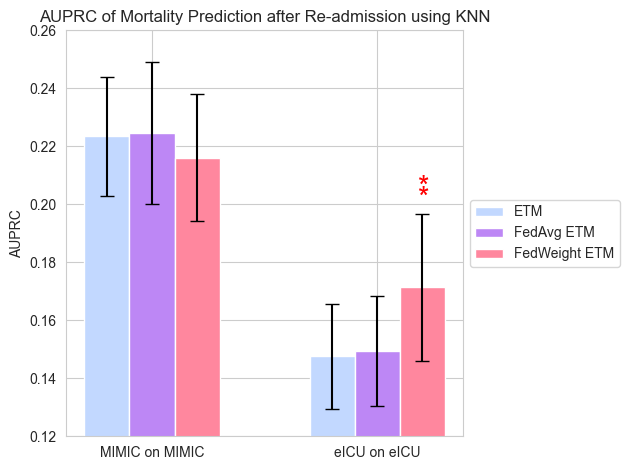

In [122]:
import matplotlib.pyplot as plt
import numpy as np

tasks = ['MIMIC on MIMIC', 'eICU on eICU']
etm_mean = [etm_mimic_on_mimic_mean_auprc, etm_eicu_on_eicu_mean_auprc]
unweighted_mean = [unweighted_mimic_on_mimic_mean_auprc, unweighted_eicu_on_eicu_mean_auprc]
weighted_mean = [weighted_mimic_on_mimic_mean_auprc, weighted_eicu_on_eicu_mean_auprc]

etm_std = [etm_mimic_on_mimic_std_auprc, etm_eicu_on_eicu_std_auprc]
unweighted_std = [unweighted_mimic_on_mimic_std_auprc, unweighted_eicu_on_eicu_std_auprc]
weighted_std = [weighted_mimic_on_mimic_std_auprc, weighted_eicu_on_eicu_std_auprc]

x = np.arange(len(tasks))

bar_width = 0.2

# Plotting the bars with error bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, etm_mean, bar_width, yerr=etm_std, capsize=5, label='ETM', color='#c2d8ff')
bar2 = ax.bar(x, unweighted_mean, bar_width, yerr=unweighted_std, capsize=5, label='FedAvg ETM', color='#bd87f5')
bar3 = ax.bar(x + bar_width, weighted_mean, bar_width, yerr=weighted_std, capsize=5, label='FedWeight ETM', color='#ff879e')

ax.set_ylabel('AUPRC')
ax.set_title('AUPRC of Mortality Prediction after Re-admission using KNN')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Compare FedAvg ETM with ETM baseline (significance)
for idx in intra_compare_etm_cauprc_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedAvg ETM with ETM baseline (very significance)
for idx in intra_compare_etm_auprc_very_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.004,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (significance)
for idx in intra_compare_unweighted_auprc_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (very significance)
for idx in intra_compare_unweighted_auprc_very_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.004,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Show the plot
plt.tight_layout()
plt.ylim(0.12, 0.26)
plt.show()

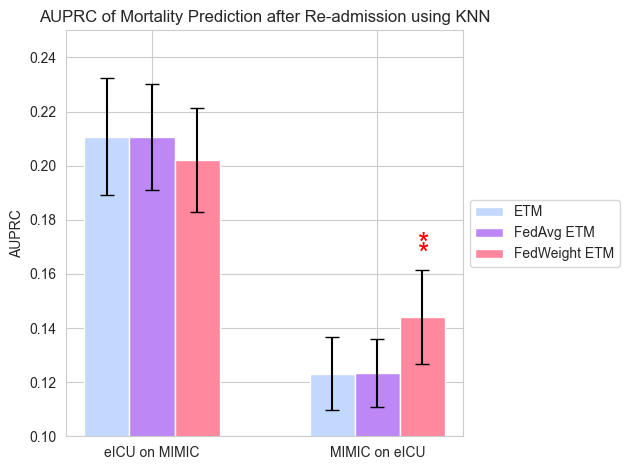

In [109]:
import matplotlib.pyplot as plt
import numpy as np

tasks = ['eICU on MIMIC', 'MIMIC on eICU']
etm_mean = [etm_eicu_on_mimic_mean_auprc, etm_mimic_on_eicu_mean_auprc]
unweighted_mean = [unweighted_eicu_on_mimic_mean_auprc, unweighted_mimic_on_eicu_mean_auprc]
weighted_mean = [weighted_eicu_on_mimic_mean_auprc, weighted_mimic_on_eicu_mean_auprc]

etm_std = [etm_eicu_on_mimic_std_auprc, etm_mimic_on_eicu_std_auprc]
unweighted_std = [unweighted_eicu_on_mimic_std_auprc, unweighted_mimic_on_eicu_std_auprc]
weighted_std = [weighted_eicu_on_mimic_std_auprc, weighted_mimic_on_eicu_std_auprc]

x = np.arange(len(tasks))

bar_width = 0.2

# Plotting the bars with error bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, etm_mean, bar_width, yerr=etm_std, capsize=5, label='ETM', color='#c2d8ff')
bar2 = ax.bar(x, unweighted_mean, bar_width, yerr=unweighted_std, capsize=5, label='FedAvg ETM', color='#bd87f5')
bar3 = ax.bar(x + bar_width, weighted_mean, bar_width, yerr=weighted_std, capsize=5, label='FedWeight ETM', color='#ff879e')

ax.set_ylabel('AUPRC')
ax.set_title('AUPRC of Mortality Prediction after Re-admission using KNN')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Compare FedAvg ETM with ETM baseline (significance)
for idx in cross_compare_etm_cauprc_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedAvg ETM with ETM baseline (very significance)
for idx in cross_compare_etm_auprc_very_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.004,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (significance)
for idx in cross_compare_unweighted_auprc_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (very significance)
for idx in cross_compare_unweighted_auprc_very_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.004,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Show the plot
plt.tight_layout()
plt.ylim(0.1, 0.25)
plt.show()

In [110]:
# from scipy.stats import ranksums
# 
# _, unweighted_etm_mimic_auroc_p_value = ranksums(unweighted_mimic_auroc_list, etm_mimic_auroc_list)
# _, weighted_etm_mimic_auroc_p_value = ranksums(weighted_mimic_auroc_list, etm_mimic_auroc_list)
# _, weighted_unweighted_mimic_auroc_p_value = ranksums(weighted_mimic_auroc_list, unweighted_mimic_auroc_list)
# 
# print("Unweighted vs ETM MIMIC AUROC p-value: ", unweighted_etm_mimic_auroc_p_value)
# print("Weighted vs ETM MIMIC AUROC p-value: ", weighted_etm_mimic_auroc_p_value)
# print("Weighted vs Unweighted MIMIC AUROC p-value: ", weighted_unweighted_mimic_auroc_p_value)

In [111]:
# from scipy.stats import ranksums
# 
# _, unweighted_etm_eicu_auroc_p_value = ranksums(unweighted_eicu_auroc_list, etm_eicu_auroc_list)
# _, weighted_etm_eicu_auroc_p_value = ranksums(weighted_eicu_auroc_list, etm_eicu_auroc_list)
# _, weighted_unweighted_eicu_auroc_p_value = ranksums(weighted_eicu_auroc_list, unweighted_eicu_auroc_list)
# 
# print("Unweighted vs ETM eicu AUROC p-value: ", unweighted_etm_eicu_auroc_p_value)
# print("Weighted vs ETM eicu AUROC p-value: ", weighted_etm_eicu_auroc_p_value)
# print("Weighted vs Unweighted eicu AUROC p-value: ", weighted_unweighted_eicu_auroc_p_value)

In [112]:
# compare_etm_auroc_significance_index = []
# compare_etm_auroc_very_significance_index = []
# 
# # Compare FedAvg ETM and ETM
# if unweighted_etm_mimic_auroc_p_value < 0.05 and etm_mimic_mean_auroc < unweighted_mimic_mean_auroc:
#     if unweighted_etm_mimic_auroc_p_value < 0.01:
#         compare_etm_auroc_very_significance_index.append(0)
#     else:
#         compare_etm_auroc_significance_index.append(0)
#         
# if unweighted_etm_eicu_auroc_p_value < 0.05 and etm_eicu_mean_auroc < unweighted_eicu_mean_auroc:
#     if unweighted_etm_eicu_auroc_p_value < 0.01:
#         compare_etm_auroc_very_significance_index.append(1)
#     else:
#         compare_etm_auroc_significance_index.append(1)
#         
# compare_unweighted_auroc_significance_index = []
# compare_unweighted_auroc_very_significance_index = []
# 
# # Compare FedWeight ETM and FedAvg ETM
# if weighted_unweighted_mimic_auroc_p_value < 0.05 and unweighted_mimic_mean_auroc < weighted_mimic_mean_auroc:
#     if weighted_unweighted_mimic_auroc_p_value < 0.01:
#         compare_unweighted_auroc_very_significance_index.append(0)
#     else:
#         compare_unweighted_auroc_significance_index.append(0)
#         
# if weighted_unweighted_eicu_auroc_p_value < 0.05 and unweighted_eicu_mean_auroc < weighted_eicu_mean_auroc:
#     if weighted_unweighted_eicu_auroc_p_value < 0.01:
#         compare_unweighted_auroc_very_significance_index.append(1)
#     else:
#         compare_unweighted_auroc_significance_index.append(1)

In [113]:
# import matplotlib.pyplot as plt
# import numpy as np
# 
# tasks = ['eICU on MIMIC', 'MIMIC on eICU']
# etm_mean = [etm_mimic_mean_auroc, etm_eicu_mean_auroc]
# unweighted_mean = [unweighted_mimic_mean_auroc, unweighted_eicu_mean_auroc]
# weighted_mean = [weighted_mimic_mean_auroc, weighted_eicu_mean_auroc]
# 
# etm_std = [etm_mimic_std_auroc, etm_eicu_std_auroc]
# unweighted_std = [unweighted_mimic_std_auroc, unweighted_eicu_std_auroc]
# weighted_std = [weighted_mimic_std_auroc, weighted_eicu_std_auroc]
# 
# x = np.arange(len(tasks))
# 
# bar_width = 0.2
# 
# # Plotting the bars with error bars
# fig, ax = plt.subplots()
# bar1 = ax.bar(x - bar_width, etm_mean, bar_width, yerr=etm_std, capsize=5, label='ETM', color='#83aef7')
# bar2 = ax.bar(x, unweighted_mean, bar_width, yerr=unweighted_std, capsize=5, label='FedAvg ETM', color='#bd87f5')
# bar3 = ax.bar(x + bar_width, weighted_mean, bar_width, yerr=weighted_std, capsize=5, label='FedWeight ETM', color='#ff879e')
# 
# ax.set_ylabel('AUROC')
# ax.set_title('AUROC of Mortality Prediction after Re-admission using KNN')
# ax.set_xticks(x)
# ax.set_xticklabels(tasks)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# 
# # Compare FedAvg ETM with ETM baseline (significance)
# for idx in compare_etm_auroc_significance_index:
#     bar_x = x[idx]
#     bar_y = unweighted_mean[idx] + unweighted_std[idx]
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='blue'
#     )
# 
# # Compare FedAvg ETM with ETM baseline (very significance)
# for idx in compare_etm_auroc_very_significance_index:
#     bar_x = x[idx]
#     bar_y = unweighted_mean[idx] + unweighted_std[idx]
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='blue'
#     )
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y + 0.006,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='blue'
#     )
# 
# # Compare FedWeight ETM with FedAvg ETM baseline (significance)
# for idx in compare_unweighted_auroc_significance_index:
# 
#     bar_x = x[idx] + bar_width
#     bar_y = weighted_mean[idx] + weighted_std[idx]
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='red'
#     )
# 
# # Compare FedWeight ETM with FedAvg ETM baseline (very significance)
# for idx in compare_unweighted_auroc_very_significance_index:
# 
#     bar_x = x[idx] + bar_width
#     bar_y = weighted_mean[idx] + weighted_std[idx]
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='red'
#     )
#     
#     plt.text(
#         bar_x,  # X-coordinate
#         bar_y + 0.006,  # Y-coordinate above the error bar
#         '*',  # Text
#         ha='center',  # Horizontal alignment
#         va='bottom',  # Vertical alignment
#         fontsize=21,
#         color='red'
#     )
# 
# # Show the plot
# plt.tight_layout()
# plt.ylim(0.42, 0.61)
# plt.show()

In [114]:
from scipy.stats import ranksums

_, unweighted_etm_eicu_on_mimic_top_k_precision_p_value = ranksums(unweighted_eicu_on_mimic_top_k_precision_scores, etm_eicu_on_mimic_top_k_precision_scores)
_, weighted_etm_eicu_on_mimic_top_k_precision_p_value = ranksums(weighted_eicu_on_mimic_top_k_precision_scores, etm_eicu_on_mimic_top_k_precision_scores)
_, weighted_unweighted_eicu_on_mimic_top_k_precision_p_value = ranksums(weighted_eicu_on_mimic_top_k_precision_scores, unweighted_eicu_on_mimic_top_k_precision_scores)

print("Unweighted vs ETM eicu_on_mimic Top K Precision p-value: ", unweighted_etm_eicu_on_mimic_top_k_precision_p_value)
print("Weighted vs ETM eicu_on_mimic Top K Precision p-value: ", weighted_etm_eicu_on_mimic_top_k_precision_p_value)
print("Weighted vs Unweighted eicu_on_mimic Top K Precision p-value: ", weighted_unweighted_eicu_on_mimic_top_k_precision_p_value)

Unweighted vs ETM eicu_on_mimic Top K Precision p-value:  0.00021934593108201132
Weighted vs ETM eicu_on_mimic Top K Precision p-value:  5.301810680185878e-07
Weighted vs Unweighted eicu_on_mimic Top K Precision p-value:  2.2844809231260737e-16


In [115]:
from scipy.stats import ranksums

_, unweighted_etm_mimic_on_eicu_top_k_precision_p_value = ranksums(unweighted_mimic_on_eicu_top_k_precision_scores, etm_mimic_on_eicu_top_k_precision_scores)
_, weighted_etm_mimic_on_eicu_top_k_precision_p_value = ranksums(weighted_mimic_on_eicu_top_k_precision_scores, etm_mimic_on_eicu_top_k_precision_scores)
_, weighted_unweighted_mimic_on_eicu_top_k_precision_p_value = ranksums(weighted_mimic_on_eicu_top_k_precision_scores, unweighted_mimic_on_eicu_top_k_precision_scores)

print("Unweighted vs ETM mimic_on_eicu Top K Precision p-value: ", unweighted_etm_mimic_on_eicu_top_k_precision_p_value)
print("Weighted vs ETM mimic_on_eicu Top K Precision p-value: ", weighted_etm_mimic_on_eicu_top_k_precision_p_value)
print("Weighted vs Unweighted mimic_on_eicu Top K Precision p-value: ", weighted_unweighted_mimic_on_eicu_top_k_precision_p_value)

Unweighted vs ETM mimic_on_eicu Top K Precision p-value:  3.1879285211981105e-17
Weighted vs ETM mimic_on_eicu Top K Precision p-value:  1.426224311709448e-07
Weighted vs Unweighted mimic_on_eicu Top K Precision p-value:  0.00025202185304447355


In [116]:
compare_etm_top_k_precision_significance_index = []
compare_etm_top_k_precision_very_significance_index = []

# Compare FedAvg ETM and ETM
if unweighted_etm_eicu_on_mimic_top_k_precision_p_value < 0.05 and etm_eicu_on_mimic_mean_top_k_precision < unweighted_eicu_on_mimic_mean_top_k_precision:
    if unweighted_etm_eicu_on_mimic_top_k_precision_p_value < 0.01:
        compare_etm_top_k_precision_very_significance_index.append(0)
    else:
        compare_etm_top_k_precision_significance_index.append(0)
        
if unweighted_etm_mimic_on_eicu_top_k_precision_p_value < 0.05 and etm_mimic_on_eicu_mean_top_k_precision < unweighted_mimic_on_eicu_mean_top_k_precision:
    if unweighted_etm_mimic_on_eicu_top_k_precision_p_value < 0.01:
        compare_etm_top_k_precision_very_significance_index.append(1)
    else:
        compare_etm_top_k_precision_significance_index.append(1)
        
compare_unweighted_top_k_precision_significance_index = []
compare_unweighted_top_k_precision_very_significance_index = []

# Compare FedWeight ETM and FedAvg ETM
if weighted_unweighted_eicu_on_mimic_top_k_precision_p_value < 0.05 and unweighted_eicu_on_mimic_mean_top_k_precision < weighted_eicu_on_mimic_mean_top_k_precision:
    if weighted_unweighted_eicu_on_mimic_top_k_precision_p_value < 0.01:
        compare_unweighted_top_k_precision_very_significance_index.append(0)
    else:
        compare_unweighted_top_k_precision_significance_index.append(0)
        
if weighted_unweighted_mimic_on_eicu_top_k_precision_p_value < 0.05 and unweighted_mimic_on_eicu_mean_top_k_precision < weighted_mimic_on_eicu_mean_top_k_precision:
    if weighted_unweighted_mimic_on_eicu_top_k_precision_p_value < 0.01:
        compare_unweighted_top_k_precision_very_significance_index.append(1)
    else:
        compare_unweighted_top_k_precision_significance_index.append(1)

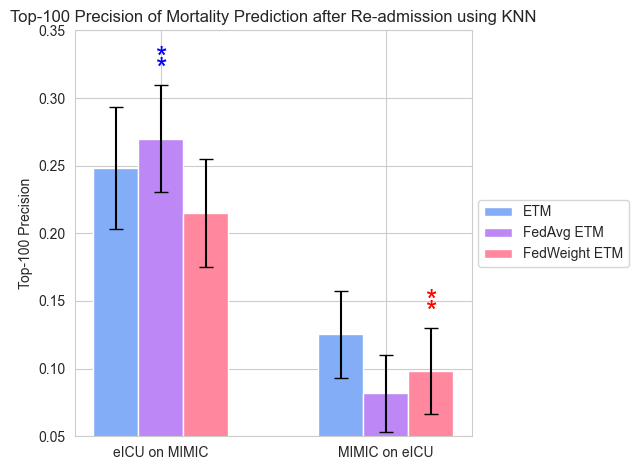

In [117]:
import matplotlib.pyplot as plt
import numpy as np

tasks = ['eICU on MIMIC', 'MIMIC on eICU']
etm_mean = [etm_eicu_on_mimic_mean_top_k_precision, etm_mimic_on_eicu_mean_top_k_precision]
unweighted_mean = [unweighted_eicu_on_mimic_mean_top_k_precision, unweighted_mimic_on_eicu_mean_top_k_precision]
weighted_mean = [weighted_eicu_on_mimic_mean_top_k_precision, weighted_mimic_on_eicu_mean_top_k_precision]

etm_std = [etm_eicu_on_mimic_std_top_k_precision, etm_mimic_on_eicu_std_top_k_precision]
unweighted_std = [unweighted_eicu_on_mimic_std_top_k_precision, unweighted_mimic_on_eicu_std_top_k_precision]
weighted_std = [weighted_eicu_on_mimic_std_top_k_precision, weighted_mimic_on_eicu_std_top_k_precision]

x = np.arange(len(tasks))

bar_width = 0.2

# Plotting the bars with error bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, etm_mean, bar_width, yerr=etm_std, capsize=5, label='ETM', color='#83aef7')
bar2 = ax.bar(x, unweighted_mean, bar_width, yerr=unweighted_std, capsize=5, label='FedAvg ETM', color='#bd87f5')
bar3 = ax.bar(x + bar_width, weighted_mean, bar_width, yerr=weighted_std, capsize=5, label='FedWeight ETM', color='#ff879e')

ax.set_ylabel('Top-100 Precision')
ax.set_title('Top-100 Precision of Mortality Prediction after Re-admission using KNN')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Compare FedAvg ETM with ETM baseline (significance)
for idx in compare_etm_top_k_precision_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedAvg ETM with ETM baseline (very significance)
for idx in compare_etm_top_k_precision_very_significance_index:
    bar_x = x[idx]
    bar_y = unweighted_mean[idx] + unweighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.0085,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='blue'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (significance)
for idx in compare_unweighted_top_k_precision_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Compare FedWeight ETM with FedAvg ETM baseline (very significance)
for idx in compare_unweighted_top_k_precision_very_significance_index:

    bar_x = x[idx] + bar_width
    bar_y = weighted_mean[idx] + weighted_std[idx]
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )
    
    plt.text(
        bar_x,  # X-coordinate
        bar_y + 0.0085,  # Y-coordinate above the error bar
        '*',  # Text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=21,
        color='red'
    )

# Show the plot
plt.tight_layout()
plt.ylim(0.05, 0.35)
plt.show()

In [119]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Patch
# from scipy.cluster.hierarchy import linkage
# 
# death_color_map = {
#     0: '#e8e8e8',
#     1: 'red'
# }
# 
# eicu_test_death_data_series = pd.Series(eicu_test_death_data, 
#                                  name='Death')
# row_colors = eicu_test_death_data_series.map(death_color_map).to_numpy()
# 
# 
# row_clusters = linkage(eicu_test_theta_weighted, method='ward')
# col_clusters = linkage(eicu_test_theta_weighted.T, method='ward')
# g = sns.clustermap(eicu_test_theta_weighted, row_linkage=row_clusters, col_linkage=col_clusters, 
#                    figsize=(5, 6),
#                    yticklabels=False, cmap='rocket_r',
#                    cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
#                    cbar_pos=(0.45, -0.05, 0.3, 0.02),
#                    row_colors=row_colors)
# 
# g.fig.suptitle(f'Heatmap FedAvg ETM Patient-Topic Mixture (MIMIC on eICU)',
#                fontsize=12, x=0.6, y=1.02)
# g.ax_heatmap.set_xlabel('Latent Dimension')
# g.ax_heatmap.set_ylabel('Patients')
# 
# legend_patches = [plt.Line2D([0], [0], marker='o', color='w', 
#                              markerfacecolor=death_color_map[status],
#                              markersize=10, label=status) for status in [0, 1]]
# plt.legend(handles=legend_patches, title='Death', bbox_to_anchor=(2.0, 12), loc='lower left', borderaxespad=0.)
# 
# plt.show()
# plt.close()

In [120]:
# row_colors.shape

In [121]:
# eicu_test_theta_unweighted.shape